# Embeddings

(Some parts of this lecture are adapted material from http://cs224d.stanford.edu/)

Deep Learning algorithms require the input to be represented as (sequences of) fixed-length feature vectors. 

Words in documents and other categorical features such as user/product ids in recommeders, names of places, visited URLs, etc. are usually represented by using a one-of-K scheme (**one-hot encoding**). Phrases are represented by bag-of-words or bag-of-ngrams features, loosing the ordering of words and ignoring semantics. 

Are these good representations for deep learning?

Let's see how to represent **words**, but this line of reasoning can be extended to other items.

There are an estimated 13 million tokens for the English language. 

One possible strategy is to encode word tokens each into some vector that represents a point in some sort of *word space* that *represents* language semantics. 

The most intuitive reason is that perhaps there actually exists some $N$-dimensional space (such that $N << 13$ million) that is sufficient to encode all semantics of our language. 

Each dimension would encode some meaning that we transfer using speech.

### One-hot encoding

If we represent every word as an $\mathbb{R}^{|V|\times 1}$ vector with all $0$s and one $1$ at the index of that word in the sorted english language, word vectors in this type of encoding would appear as the following:

<centering>
$$w^{aardvark} = \left[ \begin{array}{c} 1 \\ 0 \\ 0 \\ \vdots \\ 0 \end{array} \right], w^{a} = \left[ \begin{array}{c} 0 \\ 1 \\ 0 \\ \vdots \\ 0 \end{array} \right] , w^{at} = \left[ \begin{array}{c} 0 \\ 0 \\ 1 \\ \vdots \\ 0 \end{array} \right] , \cdot w^{zebra} = \left[ \begin{array}{c} 0 \\ 0 \\ 0 \\ \vdots \\ 1 \end{array} \right] $$
</centering>


We represent each word as a completely independent entity:

$$(w^{hotel})^Tw^{motel} = (w^{hotel})^Tw^{cat} = 0$$

What other alternatives are there?

### Semantics from word-document matrix

As our first attempt, we make the bold conjecture that words that are related will often appear in the same documents. 

For instance, "banks", "bonds", "stocks", "money", etc. are probably likely to appear together. But "banks", "octopus", "banana", and "hockey" would probably not consistently appear together. 

We use this fact to build a word-document matrix, $X$ in the following manner: 

+ Loop over billions of documents and for each time word $i$ appears in document $j$, we add one to entry $X_{ij}$. 

This is obviously a very large matrix ($\mathbb{R}^{|V|\times M}$) and it scales with the number of documents ($M$). 

So perhaps we can try something better, such as building a window based co-occurrence matrix.

In this method we count the number of times each word appears inside a window of a particular size around the word of interest. We calculate this count for all the words in corpus. 

Let our corpus contain just three sentences and the window size be 1:

+ ``I enjoy flying``.
+ ``I like NLP``.
+ ``I like deep learning``.

The resulting counts matrix will then be:

$$X=\left[ \begin{array}{cccccccc}
        & I & like & enjoy & deep & learning & NLP & flying & . \\
     I & 0 & 2 & 1 & 0 & 0 & 0 & 0 & 0\\
    like & 2 & 0 & 0 & 1 & 0 & 1 & 0 & 0\\
    enjoy & 1 & 0 & 0 & 0 & 0 & 0 & 1 & 0 \\
    deep & 0 & 1 & 0 & 0 & 1 & 0 & 0 & 0 \\
    learning & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 1\\
    NLP & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 1\\
    flying & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 1\\
    . & 0 & 0 & 0 & 0 & 1 & 1 & 1 & 0 \\
  \end{array} \right]$$

Once the $|V|\times|V|$ co-occurrence matrix $X$ has been generated, we can apply SVD on $X$ to get $X = USV^T$ and select the first $k$ columns of $U$ to get a $k$-dimensional word vectors. $\frac{\sum_{i = 1}^{k}\sigma_i}{\sum_{i = 1}^{|V|}\sigma_i}$ indicates the amount of variance captured by the first $k$ dimensions.

These vectors encode some kind of semantics but they have some problems:

+ The dimensions of the matrix can change very often (new words are added very frequently and corpus changes in size).
+ SVD based methods do not scale well for big matrices and it is hard to incorporate new words or documents. 
+ The matrix is extremely sparse since most words do not co-occur.
+ The matrix is very high dimensional in general ($\approx 10^6 \times 10^6$)
+ Quadratic cost to train (i.e. to perform SVD)
+ Requires the incorporation of some hacks on $X$ to account for the drastic imbalance in word frequency

Some solutions to exist to resolve some of the issues discussed above:
+ Ignore function words such as "the", "he", "has", etc.
+ Apply a ramp window -- i.e. weight the co-occurrence count based on distance between the words in the document. 
+ Use Pearson correlation and set negative counts to 0 instead of using just raw count.

But a NN method can solve many of these issues in a far more elegant manner....



## ``word2vec``

Instead of computing and storing global information about some huge dataset (which might be billions of sentences), we can try to create a model that will be able to learn one iteration at a time and eventually be able to encode the probability of a word given its context. 

> The **context of a word** is the set of $m$ surrounding words. For instance, the $m = 2$ context of the word ``fox`` in the sentence ``The quick brown fox jumped over the lazy dog`` is \{``quick``, ``brown``, ``jumped``, ``over``\}.

The idea is to design a model whose parameters are the word vectors. Then, train the model on a certain objective. 

At every iteration we run our model, evaluate the errors, and follow an update rule that has some notion of penalizing the model parameters that caused the error. Thus, we learn our word vectors. 

Mikolov presented a simple, probabilistic model in 2013 that is known as ``word2vec``. In fact, ``word2vec`` includes 2 algorithms (CBOW and skip-gram) and 2 training methods (negative sampling and hierarchical softmax).

> This model relies on a very important hypothesis in linguistics, *distributional similarity*, the idea that similar words have similar context.

First, we need to create such a model that will assign a probability to a sequence of tokens. Let us start with an example: ``The cat jumped over the puddle``. 

A good language model will give this sentence a high probability because this is a completely valid sentence, syntactically and semantically. Similarly, the sentence ``stock boil fish is toy`` should have a very low probability because it makes no sense. 

Mathematically, we can call this probability on any given sequence of $n$ words:

$$P(w_{1}, w_{2}, \cdots, w_{n})$$

We can take the unary language model approach and break apart this probability by assuming the word occurrences are completely independent:

$$P(w_{1}, w_{2}, \cdots, w_{n}) = \prod_{i=1}^n P(w_{i})$$

However, we know the next word is highly contingent upon the previous sequence of words. So perhaps we let the probability of the sequence depend on the pairwise probability of a word in the sequence and the word next to it. We call this the bigram model and represent it as:

$$P(w_{1}, w_{2}, \cdots, w_{n}) = \prod_{i=2}^n P(w_{i} | w_{i-1})$$

Again this is certainly a bit naive since we are only concerning ourselves with pairs of neighboring words rather than evaluating a whole sentence, but as we will see, this representation gets us pretty far along. Note in the Word-Word Matrix with a context of size 1, we basically can learn these pairwise probabilities. But again, this would require computing and storing global information about a massive dataset.

### Continuous Bag of Words Model (CBOW)

The approach is to treat {``The``, ``cat``, ``over``, ``the``, ``puddle``} as a context and from these words, be able to predict or generate the center word ``jumped``. 

First, we set up our known parameters. Let the known parameters in our model be the sentence represented by one-hot word vectors. 

The input one hot vectors or context will represented with an $x^{(c)}$. And the output as $y$ which is the one hot vector of the known center word. 

Now let's define our unknowns in our model. 

We create two matrices, $\mathcal{V} \in \mathbb{R}^{n\times|V|}$ and $\mathcal{U} \in \mathbb{R}^{|V|\times n}$, where $n$ is an arbitrary size which defines the size of our embedding space. 

$\mathcal{V}$ is the input word matrix such that the $i$-th column of $\mathcal{V}$ is the $n$-dimensional **embedded vector** for word $w_{i}$ when it is an input to this model. We denote this $n\times1$ vector as $v_{i}$. 

Similarly, $\mathcal{U}$ is the output word matrix. The $j$-th row of $\mathcal{U}$ is an $n$-dimensional embedded vector for word $w_{j}$ when it is an output of the model. We denote this row of $\mathcal{U}$ as $u_{j}$. Note that we do in fact learn two vectors for every word $w_{i}$ (i.e. input word vector $v_{i}$ and output word vector $u_{i}$).

We breakdown the way this model works in these steps:
+ We generate our one hot word vectors  for the input context of size $m : (x^{(c-m)}, \dots, x^{(c-1)}, x^{(c+1)},\dots, x^{(c+m)} \in \mathbb{R}^{|V|}$).

+ We get our embedded word vectors for the context ($v_{c-m}=\mathcal{V}x^{(c-m)}, v_{c-m+1}=\mathcal{V}x^{(c-m+1)}, \dots, v_{c+m}=\mathcal{V}x^{(c+m)} \in \mathbb{R}^n$) 

<center>
<img src="images/w2v1.png" alt="" style="width: 400px;"/> 
</center>


+ Average these vectors to get $h = \frac{v_{c-m}+v_{c-m+1}+... + v_{c+m}}{2m} \in \mathbb{R}^n$
+ Generate a score vector $z=\mathcal{U}h \in \mathbb{R}^{|V|}$. As the dot product of similar vectors is higher, it will push similar words close to each other in order to achieve a high score.
+ Turn the scores into probabilities $\hat{y}=\operatorname{softmax}(z) \in \mathbb{R}^{|V|}$. 
+ We desire our probabilities generated, $\hat{y} \in \mathbb{R}^{|V|}$, to match the true probabilities, $y \in \mathbb{R}^{|V|}$, which also happens to be the one hot vector of the actual word.

How can we learn these two matrices? Well, we need to create an objective function. 

Here, we use a popular choice of distance/loss measure, cross entropy $H(\hat{y},y)$. 

We thus formulate our optimization objective as:

$$
\mbox{minimize } J = -\log P(w_{c}|w_{c-m}, \dots, w_{c-1}, w_{c+1}, \dots, w_{c+m}) \\
= -\log P(u_{c}|h) \\
= -\log \frac{\exp(u_{c}^{T}h)}{\sum_{j=1}^{|V|}\exp(u_{j}^{T}h)} \\
= -u_{c}^{T}h+\log \sum_{j=1}^{|V|}\exp(u_{j}^{T}h) \\
$$

We use stochastic gradient descent to update all relevant word vectors $u_{c}$ and $v_{j}$.


<center>
<img src="images/word2vec-cbow.png" alt="" style="width: 400px;"/> 
</center>

### Skip-gram model

Another approach is to create a model such that given the center word ``jumped``, the model will be able to predict or generate the surrounding words ``The``, ``cat``, ``over``, ``the``, ``puddle``. Here we call the word ``jumped`` the context. We call this type of model a Skip-Gram model.


<center>
<img src="images/fword2vec-sg.png" alt="" style="width: 400px;"/> 
</center>


## A ``word2vec`` implementation

A word embedding layer is usually regarded as a mapping from a discrete set of objects (words) to a real valued vector, i.e. 

$$k\in\{1..|V|\} \rightarrow \mathbb{R}^{n}$$

Thus, we can represent the *Embedding layer* as $|V|\times n$ matrix, or just a table/dictionary.

$$
\begin{matrix}
word_1: \\
word_2:\\
\vdots\\
word_{|V|}: \\
\end{matrix}
\left[
\begin{matrix}
x_{1,1}&x_{1,2}& \dots &x_{1,n}\\
x_{2,1}&x_{2,2}& \dots &x_{2,n}\\
\vdots&&\\
x_{{|V|},1}&x_{{|V|},2}& \dots &x_{{|V|},n}\\
\end{matrix}
\right]
$$

In this sense, the basic operation that an embedding layer has to accomplish is that given a certain word it returns the assigned code. And the goal in learning is to learn the values in the matrix.

Let's see how to code a skip-gram model (This code is based on the word2vec example from Udacity).

In [4]:
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

In [5]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
    """Download a file if not present, and make sure it's the right size."""
    if not os.path.exists(filename):
        filename, _ = urlretrieve(url + filename, filename)
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified %s' % filename)
    else:
        print(statinfo.st_size)
        raise Exception('Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


In [6]:
def read_data(filename):
    """Extract the first file enclosed in a zip file as a list of words"""
    with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


In [7]:
vocabulary_size = 50000

def build_dataset(words):
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count = unk_count + 1
        data.append(index)
    count[0][1] = unk_count
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
    return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156]


In [8]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [ skip_window ]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['as', 'anarchism', 'originated', 'a', 'term', 'as', 'of', 'a']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['originated', 'a', 'term', 'anarchism', 'term', 'of', 'as', 'originated']


In [11]:
batch_size = 128
embedding_size = 64 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

    # Input data.
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
    # Variables.
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],stddev=1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
    # Model.
    # Look up embeddings for inputs.
    embed = tf.nn.embedding_lookup(embeddings, train_dataset)
    # Compute the softmax loss, using a sample of the negative labels each time.
    loss = tf.reduce_mean(
        tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, embed,
                               train_labels, num_sampled, vocabulary_size))

    # Optimizer.
    # Note: The optimizer will optimize the softmax_weights AND the embeddings.
    # This is because the embeddings are defined as a variable quantity and the
    # optimizer's `minimize` method will by default modify all variable quantities 
    # that contribute to the tensor it is passed.
    # See docs on `tf.train.Optimizer.minimize()` for more details.
    optimizer = tf.train.AdagradOptimizer(0.01).minimize(loss)
  
    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [ ]:
num_steps = 500001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    average_loss = 0
    for step in range(1,num_steps):
        batch_data, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        if step % 2500 == 0:
            if step > 0:
                average_loss = average_loss / 2500
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step %d: %f' % (step, average_loss))
            average_loss = 0
        # note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 50000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 2500: 9.071713
Average loss at step 5000: 8.402053
Average loss at step 7500: 7.846730
Average loss at step 10000: 7.342728
Average loss at step 12500: 7.256353
Average loss at step 15000: 7.194909
Average loss at step 17500: 7.017790
Average loss at step 20000: 6.855910
Average loss at step 22500: 6.837625
Average loss at step 25000: 6.868614
Average loss at step 27500: 6.745917
Average loss at step 30000: 6.656481
Average loss at step 32500: 6.543495
Average loss at step 35000: 6.586107
Average loss at step 37500: 6.502508


In [45]:
##### DUMP
import pickle
f = open('myembedding.pkl','wb')
pickle.dump([final_embeddings,dictionary,reverse_dictionary],f)
f.close()

In [46]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

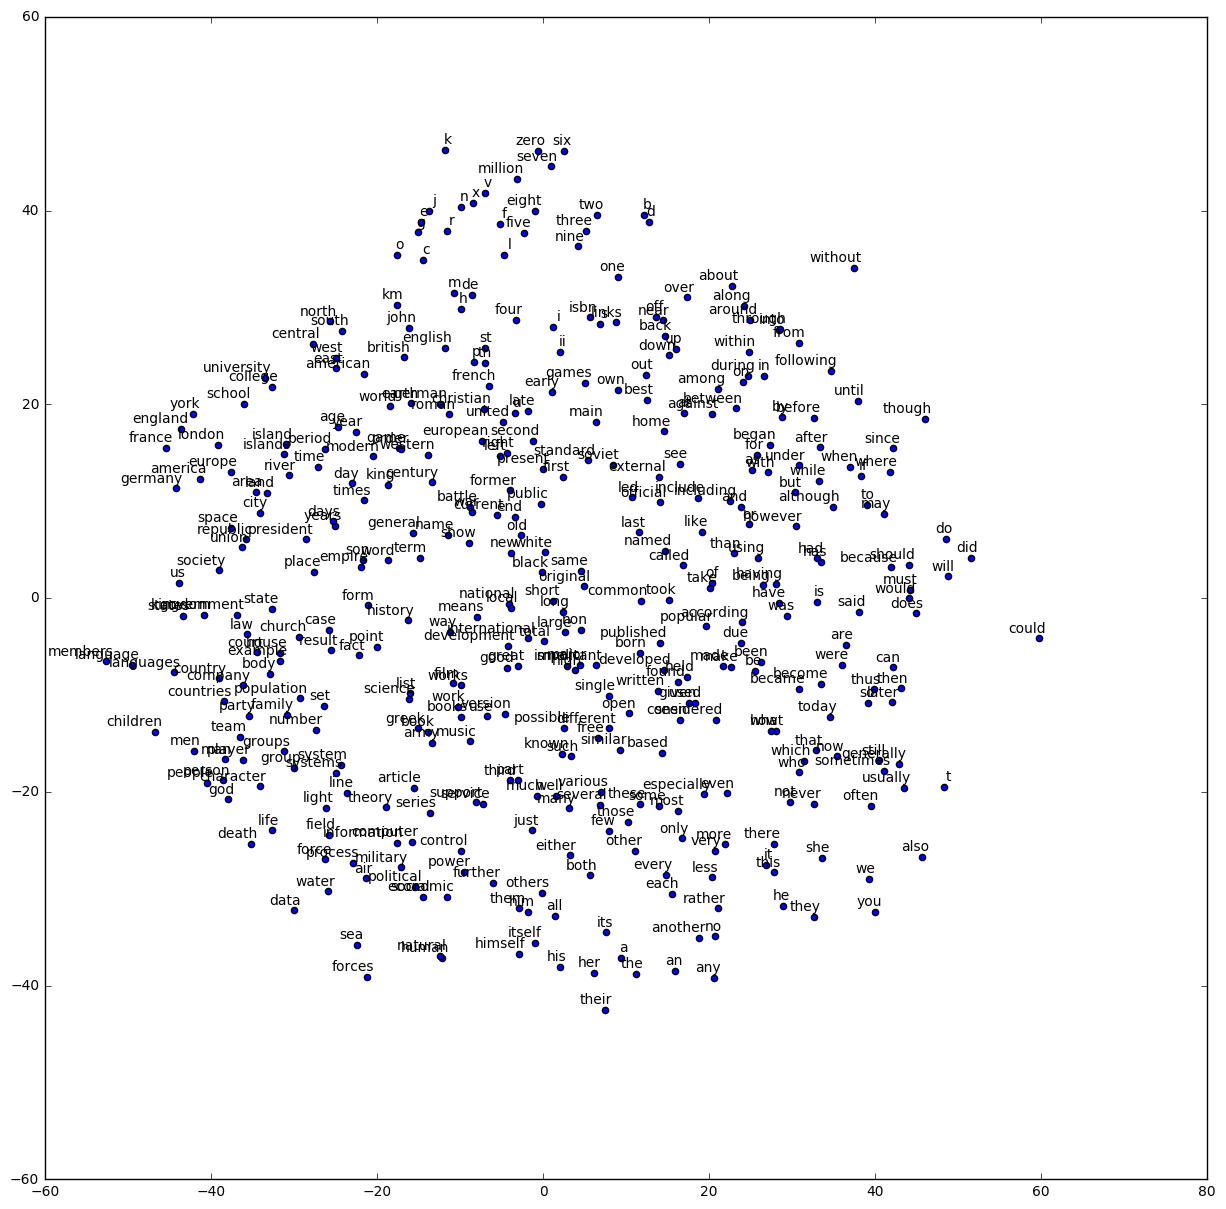

In [47]:
def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15,15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
    pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

In the former code we have the `dictionary` that converts from the word to an index, and the `reverse_dictionary` that given an index returns the corresponding word.

In [48]:
import pickle

f = open('myembedding500000.pkl','rb')
fe,dic,rdic=pickle.load(f)
f.close()

In [49]:
dic['woman']

1014

In [50]:
rdic[42]

'but'

The embedding tries to put together words with similar meaning. A good embedding allows to semantically operate. Let us check some simple semantical operations:

In [51]:
result = (fe[dic['two'],:]+ fe[dic['one'],:])

In [52]:
from scipy.spatial import distance
candidates=np.argsort(distance.cdist(fe,result[np.newaxis,:],metric="seuclidean"),axis=0)

for i in xrange(5):
    idx=candidates[i][0]
    print(rdic[idx])

two
one
three
four
five


We can also define word analogies: `football is to ? as foot is to hand`


In [53]:
result = (fe[dic['football'],:] - fe[dic['foot'],:] + fe[dic['hand'],:])

from scipy.spatial import distance
candidates=np.argsort(distance.cdist(fe,result[np.newaxis,:],metric="seuclidean"),axis=0)

for i in xrange(5):
    idx=candidates[i][0]
    print(rdic[idx])

football
hand
baseball
chess
hockey


In [55]:
result = (fe[dic['barcelona'],:] - fe[dic['spain'],:] + fe[dic['germany'],:])

from scipy.spatial import distance
candidates=np.argsort(distance.cdist(fe,result[np.newaxis,:],metric="seuclidean"),axis=0)

for i in xrange(5):
    idx=candidates[i][0]
    print(rdic[idx])

barcelona
germany
berlin
oyster
theseus


Let us used a pretrained embedding. We will use a simple embedding detailed in `Improving Word Representations via Global Context and Multiple Word Prototypes`

In [56]:
import pandas as pd
import zipfile 

zfile = zipfile.ZipFile('data/wordVectors.txt.zip')
zfile.extractall("data/")

df = pd.read_table("data/wordVectors.txt",delimiter=" ",header=None)

embedding=df.values[:,:-1]

In [57]:
f = open("data/vocab.txt",'r')
dictionary=dict()
for word in f.readlines():
    dictionary[word] = len(dictionary)
    
reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 

In [58]:
result = embedding[dictionary['king\n'],:]-embedding[dictionary['man\n'],:]+embedding[dictionary['girl\n'],:]
import numpy as np
from scipy.spatial import distance
candidates=np.argsort(distance.cdist(embedding,result[np.newaxis,:],metric="seuclidean"),axis=0)

for i in xrange(0,5):
    idx=candidates[i][0]
    print(reverse_dictionary[idx])

prince

king

princess

queen

bride



In [60]:
result = (fe[dic['spain'],:] - fe[dic['barcelona'],:] + fe[dic['germany'],:])

from scipy.spatial import distance
candidates=np.argsort(distance.cdist(fe,result[np.newaxis,:],metric="seuclidean"),axis=0)

for i in xrange(5):
    idx=candidates[i][0]
    print(rdic[idx])

germany
spain
italy
britain
france


## ``par2vec``

What about a vector representation for phrases/paragraphs/documents?

The ``par2vec`` approach for learning paragraph vectors is inspired by the methods for learning the word vectors. The inspiration is that the word vectors are asked to contribute to a prediction task about the next word in the sentence.

We will consider a *paragraph* vector. The paragraph vectors are also
asked to contribute to the prediction task of the next word
given many contexts sampled from the paragraph.

In ``par2vec`` framework, every paragraph is mapped to a unique vector, represented by a column in matrix D and every word is also mapped to a unique vector, represented by a column in matrix W. The paragraph vector and word vectors are averaged or concatenated to predict the next word in a context.

<center>
<img src="images/par2vec.png" alt="" style="width: 500px;"/> 
(Source: https://cs.stanford.edu/~quocle/paragraph_vector.pdf)
</center>

The paragraph token can be thought of as another word. It acts as a memory that remembers what is missing from the
current context – or the topic of the paragraph. For this reason, we often call this model the Distributed Memory
Model of Paragraph Vectors (PV-DM).

The contexts are fixed-length and sampled from a sliding window over the paragraph. 

The paragraph vector is shared across all contexts generated from the same paragraph but not across paragraphs. 

The word vector matrix W, however, is shared across paragraphs. 

At prediction time, one needs to perform an inference step to compute the paragraph vector for a new paragraph. This
is also obtained by gradient descent. In this step, the parameters for the rest of the model, the word vectors and
the softmax weights, are fixed.

### Using GloVe pre-trained word embeddings for classification.

GloVe (https://nlp.stanford.edu/pubs/glove.pdf) consists of a weighted least squares model that trains on global word-word co-occurrence counts and thus makes efficient use of statistics. The model produces a word vector space with meaningful sub-structure. It shows state-of-the-art performance on the word analogy task, and outperforms other current methods on several word similarity tasks.



In [ ]:
'''This script loads pre-trained word embeddings (GloVe embeddings)
into a frozen Keras Embedding layer, and uses it to
train a text classification model on the 20 Newsgroup dataset
(classication of newsgroup messages into 20 different categories).
GloVe embedding data can be found at:
http://nlp.stanford.edu/data/glove.6B.zip (822MB)
(source page: http://nlp.stanford.edu/projects/glove/)
20 Newsgroup data can be found at:
http://www.cs.cmu.edu/afs/cs.cmu.edu/project/theo-20/www/data/news20.html
'''

from __future__ import print_function

import os
import sys
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model

def to_categorical(y, num_classes=None):
    """Converts a class vector (integers) to binary class matrix.
    E.g. for use with categorical_crossentropy.
    # Arguments
        y: class vector to be converted into a matrix
            (integers from 0 to num_classes).
        num_classes: total number of classes.
    # Returns
        A binary matrix representation of the input.
    """
    y = np.array(y, dtype='int').ravel()
    if not num_classes:
        num_classes = np.max(y) + 1
    n = y.shape[0]
    categorical = np.zeros((n, num_classes))
    categorical[np.arange(n), y] = 1
    return categorical

BASE_DIR = ''
GLOVE_DIR = BASE_DIR + '/glove.6B/'
TEXT_DATA_DIR = BASE_DIR + '/20_newsgroup/'
MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

# first, build index mapping words in the embeddings set
# to their embedding vector

print('Indexing word vectors.')

embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

# second, prepare text samples and their labels
print('Processing text dataset')

texts = []  # list of text samples
labels_index = {}  # dictionary mapping label name to numeric id
labels = []  # list of label ids
for name in sorted(os.listdir(TEXT_DATA_DIR)):
    path = os.path.join(TEXT_DATA_DIR, name)
    if os.path.isdir(path):
        label_id = len(labels_index)
        labels_index[name] = label_id
        for fname in sorted(os.listdir(path)):
            if fname.isdigit():
                fpath = os.path.join(path, fname)
                if sys.version_info < (3,):
                    f = open(fpath)
                else:
                    f = open(fpath, encoding='latin-1')
                t = f.read()
                i = t.find('\n\n')  # skip header
                if 0 < i:
                    t = t[i:]
                texts.append(t)
                f.close()
                labels.append(label_id)

print('Found %s texts.' % len(texts))

# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
x_val = data[-num_validation_samples:]
y_val = labels[-num_validation_samples:]

print('Preparing embedding matrix.')

# prepare embedding matrix
num_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NB_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

print('Training model.')

# train a 1D convnet with global maxpooling
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(35)(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(len(labels_index), activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

model.fit(x_train, y_train,
          batch_size=128,
          epochs=10,
          validation_data=(x_val, y_val))